In [ ]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ISR Dataset/IMDB Dataset.csv')

data['review'] = data['review'].str.lower()

In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because",
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [ ]:
def remove_stopwords(data):
  data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

data_without_stopwords = remove_stopwords(data)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')


In [ ]:
reviews_list = []
for i in range(len(data['review'])):
  reviews_list.append(data['review'][i])
  sentiment = data_without_stopwords['sentiment']

In [ ]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiment)))

X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.2, random_state = 45)


In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [ ]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/ISR Dataset/glove.6B.50d.txt')

maxLen = 150

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)


In [ ]:
from keras.layers import Bidirectional

In [ ]:
#model=imdb_rating(input_shape)
def imdb_rating(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X =Bidirectional(LSTM(128, return_sequences=True))(embeddings)

  X = Dropout(0.3)(X)

  X = Bidirectional(LSTM(128))(X)

  X = Dropout(0.3)(X)

  #X = LSTM(128)(X)
  #X = Dense(64)
  #X = Dropout(0.3)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model = imdb_rating((maxLen,))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           5612100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 256)          183296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257 

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(40000, 150)

In [ ]:
adam = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(X_train_indices, Y_train,validation_split=0.2 , batch_size=128, epochs=15)

Epoch 1/15
250/250 [==============================] - 19s 60ms/step - loss: 0.6206 - accuracy: 0.6360 - val_loss: 0.4798 - val_accuracy: 0.7764
Epoch 2/15
250/250 [==============================] - 14s 54ms/step - loss: 0.4781 - accuracy: 0.7734 - val_loss: 0.4444 - val_accuracy: 0.8051
Epoch 3/15
250/250 [==============================] - 14s 55ms/step - loss: 0.4564 - accuracy: 0.7921 - val_loss: 0.4373 - val_accuracy: 0.7990
Epoch 4/15
250/250 [==============================] - 14s 55ms/step - loss: 0.4090 - accuracy: 0.8157 - val_loss: 0.3765 - val_accuracy: 0.8369
Epoch 5/15
250/250 [==============================] - 14s 56ms/step - loss: 0.3883 - accuracy: 0.8282 - val_loss: 0.3877 - val_accuracy: 0.8282
Epoch 6/15
250/250 [==============================] - 14s 56ms/step - loss: 0.3458 - accuracy: 0.8468 - val_loss: 0.3688 - val_accuracy: 0.8328
Epoch 7/15
250/250 [==============================] - 14s 56ms/step - loss: 0.3364 - accuracy: 0.8519 - val_loss: 0.3450 - val_accuracy:

In [ ]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [ ]:
model.evaluate(X_test_indices,Y_test)

313/313 [==============================] - 5s 15ms/step - loss: 0.3179 - accuracy: 0.8646


[0.3179417848587036, 0.8646000027656555]

In [ ]:
preds = model.predict(X_test_indices)

In [ ]:
n = np.random.randint(0,9999)

X_test[n]


'some guys think that sniper is not good because of the action part of it was not good enough. well, if you regard it as an action movie, this view point could be quite true as the action part of this movive is not actually exciting. however, i think this is a psychological drama rather than an action one.<br /><br />the movie mainly told us about the inside of two snipers who definitely had different personalities and different experiences. tomas beccket , who was a veteran and had 74 confirmed kills, looked as if he was cold-hearted. however, after beccket showed his day dream of montana, we can clearly see his softness inside. it was the cruel war and his partners\' sacrifice that made beccket become so called cold-hearted.<br /><br />millar, on the contrary, was a new comer, a green hand, and was even not qualified as a sniper. billy zane did quite well to show millar\'s hesitation and fear when he first tried to "put a bullet through one\'s heart"(as what beccket said). what he th

In [ ]:
if preds[n] > 0.5:
  print('predicted sentiment : positive')
else:
  print('precicted sentiment : negative')

if (Y_test[n] == 1):
  print('correct sentiment : positive')
else:
  print('correct sentiment : negative')


predicted sentiment : positive
correct sentiment : positive


In [ ]:
preds[n]

array([0.6128101], dtype=float32)

In [ ]:
Y_test[n]

1

In [ ]:
model.save_weights('/content/drive/MyDrive/ISR Dataset/imdb_weights_Glove_Newimproved_Bilstm.hdf5')

In [ ]:
import matplotlib.pyplot as plt

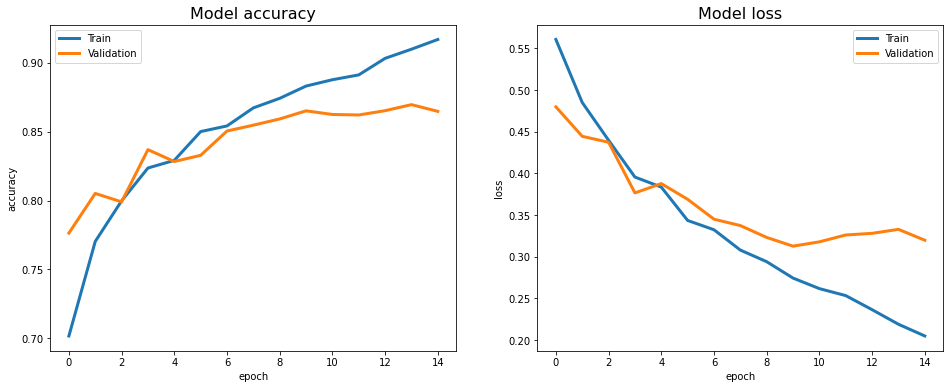

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
reviews_list_idx = tokenizer.texts_to_sequences(reviews_list)

In [ ]:
def add_score_predictions(data, reviews_list_idx):

  data['sentiment score'] = 0

  reviews_list_idx = pad_sequences(reviews_list_idx, maxlen=maxLen, padding='post')

  review_preds = model.predict(reviews_list_idx)

  data['sentiment score'] = review_preds

  pred_sentiment = np.array(list(map(lambda x : 'positive' if x > 0.5 else 'negative',review_preds)))

  data['predicted sentiment'] = 0

  data['predicted sentiment'] = pred_sentiment

  return data



In [ ]:
data = add_score_predictions(data, reviews_list_idx)

In [ ]:
data

,review,sentiment,review without stopwords,clean_review,sentiment score,predicted sentiment
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching just 1 oz epi...,one reviewers mentioned watching just 1 oz epi...,0.636769,positive
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...,0.997572,positive
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...,0.941134,positive
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zomb...,0.008051,negative
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...",petter mattei s love time money visually stu...,0.972036,positive
...,...,...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,thought movie right good job. wasn't creative ...,thought movie right good job wasn t creative ...,0.999347,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di...",bad plot bad dialogue bad acting idiotic di...,0.002653,negative
49997,i am a catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...,catholic taught parochial elementary schools n...,0.116704,negative
49998,i'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...,going disagree previous comment side maltin on...,0.431916,negative


In [ ]:
z_original = np.array(list(map(lambda x: 1 if x=="positive" else 0, data.sentiment)))

In [ ]:
z_predicted= np.array(list(map(lambda x: 1 if x=="positive" else 0, data['predicted sentiment'])))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
matrix = confusion_matrix(z_original,z_predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(z_original,z_predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(z_original,z_predicted,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[22501  2499]
 [ 2013 22987]]
Outcome values : 
 22501 2499 2013 22987
Classification report : 
               precision    recall  f1-score   support

           1       0.92      0.90      0.91     25000
           0       0.90      0.92      0.91     25000

    accuracy                           0.91     50000
   macro avg       0.91      0.91      0.91     50000
weighted avg       0.91      0.91      0.91     50000



In [ ]:
import seaborn as sb

In [ ]:
def plot_confusion_matrix(z_original, z_predicted, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(z_original,z_predicted)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

"plot_confusion_matrix(y_test, y_test_pred, ax=axis2,\n                      title='Confusion matrix (test data)',\n                      class_names=['Positive', 'Negative'])"

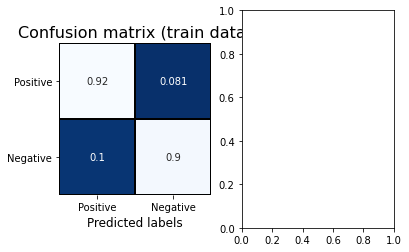

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(z_original, z_predicted, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
'''plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])'''